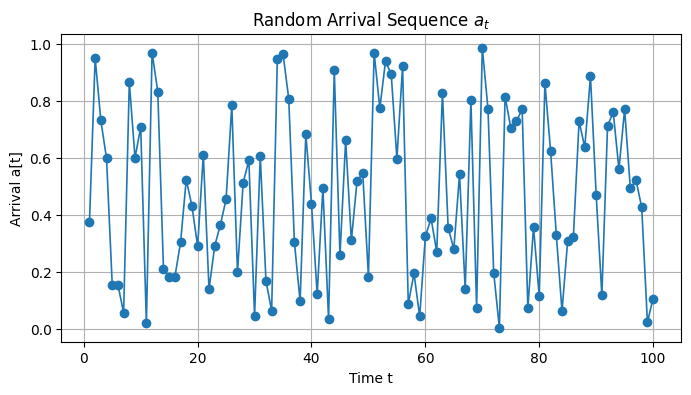

First 10 arrivals: [0.375 0.951 0.732 0.599 0.156 0.156 0.058 0.866 0.601 0.708]


In [29]:
# --- Adversarial Storage Control: Step 1 ---
# Generate and plot a random arrival sequence

import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Define the time horizon
T = 100  # you can change this value later
# Generate random arrivals between 0 and 1
a = np.random.rand(T)

# Plot the arrival sequence
plt.figure(figsize=(8, 4))
plt.plot(range(1, T + 1), a, marker='o', linestyle='-', linewidth=1.2)
plt.title("Random Arrival Sequence $a_t$")
plt.xlabel("Time t")
plt.ylabel("Arrival a[t]")
plt.grid(True)
plt.show()

# Print the first few elements
print("First 10 arrivals:", np.round(a[:10], 3))


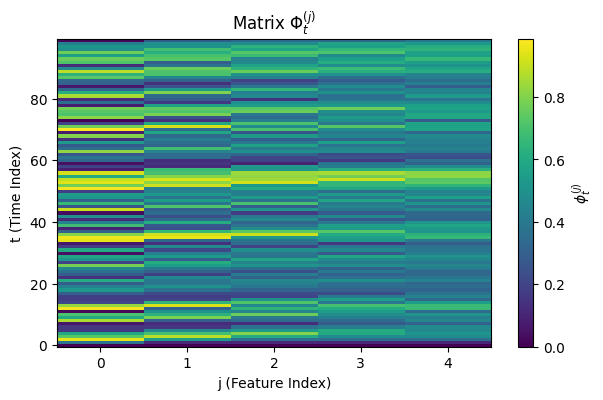

First 5 rows of Phi:
[[0.    0.    0.    0.    0.   ]
 [0.375 0.112 0.112 0.112 0.112]
 [0.951 0.547 0.364 0.364 0.364]
 [0.732 0.885 0.603 0.474 0.474]
 [0.599 0.692 0.799 0.602 0.512]]


In [30]:
# --- Step 2: Construct phi_t^{(j)} matrix with exponential lag weights ---

# Parameters
H = 5           # number of features / horizon depth
kappa = 0.3     # smoothing parameter in [0,1]

# Initialize Phi matrix
Phi = np.zeros((T, H))

# Define zero-padded arrival function
def get_a(t):
    """Return a_t with zero padding for t <= 0."""
    return a[t - 1] if t > 0 else 0.0

# Compute phi_t^{(j)} for all t, j
for t in range(1, T + 1):
    for j in range(1, H + 1):
        # First term: κ * sum_{i=1}^{j-1} (1-κ)^{i-1} a_{t-i}
        term1 = kappa * sum((1 - kappa)**(i - 1) * get_a(t - i) for i in range(1, j))
        # Second term: (1-κ)^{j-1} a_{t-j}
        term2 = (1 - kappa)**(j - 1) * get_a(t - j)
        Phi[t - 1, j - 1] = term1 + term2

# Visualize Phi as a heatmap
plt.figure(figsize=(7, 4))
plt.imshow(Phi, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label=r'$\phi_t^{(j)}$')
plt.xlabel('j (Feature Index)')
plt.ylabel('t (Time Index)')
plt.title(r'Matrix $\Phi_t^{(j)}$')
plt.show()

# Inspect first few rows
print("First 5 rows of Phi:")
print(np.round(Phi[:5, :], 3))


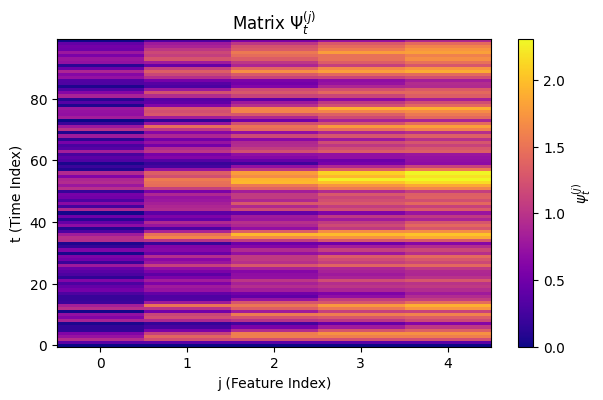

First 5 rows of Psi:
[[0.    0.    0.    0.    0.   ]
 [0.375 0.375 0.375 0.375 0.375]
 [0.951 1.213 1.213 1.213 1.213]
 [0.732 1.397 1.581 1.581 1.581]
 [0.599 1.111 1.577 1.705 1.705]]


In [31]:
# --- Step 3: Construct psi_t^{(j)} matrix ---

# Initialize Psi matrix
Psi = np.zeros((T, H))

# Compute psi_t^{(j)} for all t, j
for t in range(1, T + 1):
    for j in range(1, H + 1):
        Psi[t - 1, j - 1] = sum((1 - kappa)**(i - 1) * get_a(t - i) for i in range(1, j + 1))

# Visualize Psi as a heatmap
plt.figure(figsize=(7, 4))
plt.imshow(Psi, aspect='auto', origin='lower', cmap='plasma')
plt.colorbar(label=r'$\psi_t^{(j)}$')
plt.xlabel('j (Feature Index)')
plt.ylabel('t (Time Index)')
plt.title(r'Matrix $\Psi_t^{(j)}$')
plt.show()

# Inspect first few rows
print("First 5 rows of Psi:")
print(np.round(Psi[:5, :], 3))


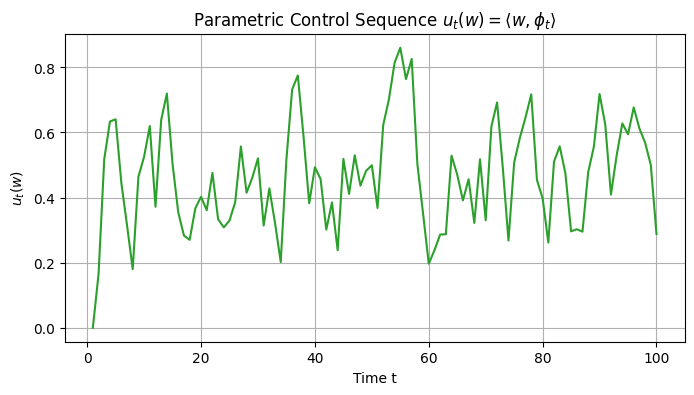

First 10 values of u_t(w): [0.     0.1648 0.5179 0.6337 0.6406 0.4454 0.3149 0.1801 0.4637 0.5254]


In [32]:
# --- Step 4: Define parametric control function u_t(w) = <w, phi_t> ---

import numpy as np

# Assume Phi is already defined (T x H)
# w is a parameter vector in R^H, typically in the simplex (nonnegative, sums to 1)

def u_t(t, w, Phi):
    """
    Compute u_t(w) = <w, phi_t> for given t (1-indexed) and weight vector w.

    Parameters
    ----------
    t : int
        Time index (1 <= t <= T)
    w : np.ndarray, shape (H,)
        Parameter vector (should lie in the probability simplex)
    Phi : np.ndarray, shape (T, H)
        Feature matrix from previous step.

    Returns
    -------
    float
        The scalar value u_t(w).
    """
    phi_t = Phi[t - 1, :]  # extract row for time t
    return np.dot(w, phi_t)

# Example: choose w on the probability simplex
H = Phi.shape[1]
w = np.ones(H) / H   # uniform simplex weight

# Compute the entire u_t sequence for this w
u_seq = np.array([u_t(t, w, Phi) for t in range(1, T + 1)])

# Plot u_t(w)
plt.figure(figsize=(8, 4))
plt.plot(range(1, T + 1), u_seq, color='tab:green', linewidth=1.5)
plt.title(r"Parametric Control Sequence $u_t(w) = \langle w, \phi_t \rangle$")
plt.xlabel("Time t")
plt.ylabel(r"$u_t(w)$")
plt.grid(True)
plt.show()

# Inspect first few values
print("First 10 values of u_t(w):", np.round(u_seq[:10], 4))


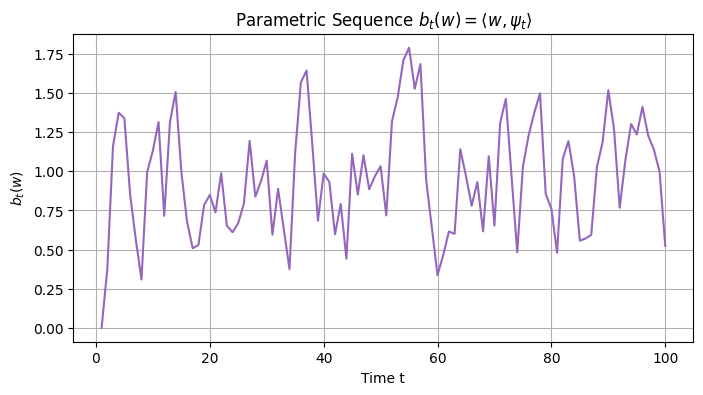

First 10 values of b_t(w): [0.     0.3745 1.1605 1.3745 1.3395 0.8549 0.5655 0.3086 0.9947 1.1321]


In [33]:
# --- Step 5: Define parametric function b_t(w) = <w, psi_t> ---

def b_t(t, w, Psi):
    """
    Compute b_t(w) = <w, psi_t> for given t (1-indexed) and weight vector w.

    Parameters
    ----------
    t : int
        Time index (1 <= t <= T)
    w : np.ndarray, shape (H,)
        Parameter vector (should lie in the probability simplex)
    Psi : np.ndarray, shape (T, H)
        Feature matrix computed from the arrival sequence.

    Returns
    -------
    float
        The scalar value b_t(w).
    """
    psi_t = Psi[t - 1, :]  # extract row for time t
    return np.dot(w, psi_t)

# Example: use same simplex weight vector
w = np.ones(H) / H

# Compute b_t(w) sequence for all t
b_seq = np.array([b_t(t, w, Psi) for t in range(1, T + 1)])

# Plot b_t(w)
plt.figure(figsize=(8, 4))
plt.plot(range(1, T + 1), b_seq, color='tab:purple', linewidth=1.5)
plt.title(r"Parametric Sequence $b_t(w) = \langle w, \psi_t \rangle$")
plt.xlabel("Time t")
plt.ylabel(r"$b_t(w)$")
plt.grid(True)
plt.show()

# Inspect first few values
print("First 10 values of b_t(w):", np.round(b_seq[:10], 4))


Optimal w* = [0. 0. 0. 0. 1.]
Sum of weights = 1.0000000000000047


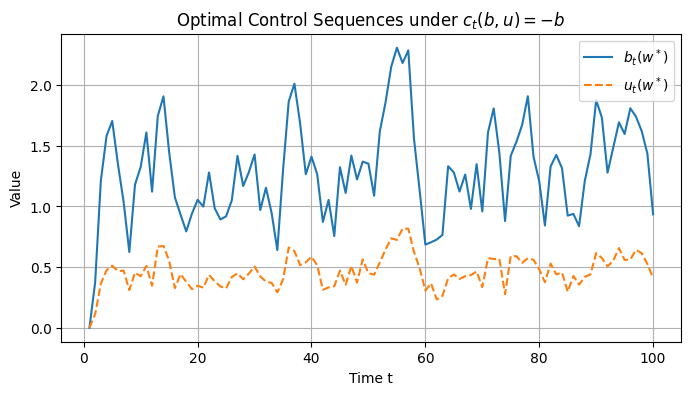

In [34]:
# --- Step 6: Solve for w* minimizing sum_t c_t(b_t(w), u_t(w))
# Example 1: c_t(b, u) = -b

import cvxpy as cp

# Define variables and parameters
w = cp.Variable(H, nonneg=True)              # w >= 0
Psi_sum = np.sum(Psi, axis=0)                # sum_t psi_t

# Define objective: minimize sum_t (-b_t(w)) = -<w, sum_t psi_t>
objective = cp.Minimize(-Psi_sum @ w)

# Simplex constraint: sum_i w_i = 1
constraints = [cp.sum(w) == 1]

# Define and solve problem
prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

# Extract optimal weight vector
w_star = w.value
print("Optimal w* =", np.round(w_star, 4))
print("Sum of weights =", np.sum(w_star))

# Evaluate resulting sequences
b_star = np.array([b_t(t, w_star, Psi) for t in range(1, T + 1)])
u_star = np.array([u_t(t, w_star, Phi) for t in range(1, T + 1)])

# Plot b_t(w*) and u_t(w*)
plt.figure(figsize=(8, 4))
plt.plot(range(1, T + 1), b_star, label=r"$b_t(w^*)$", linewidth=1.5)
plt.plot(range(1, T + 1), u_star, label=r"$u_t(w^*)$", linewidth=1.5, linestyle='--')
plt.title(r"Optimal Control Sequences under $c_t(b,u) = -b$")
plt.xlabel("Time t")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()


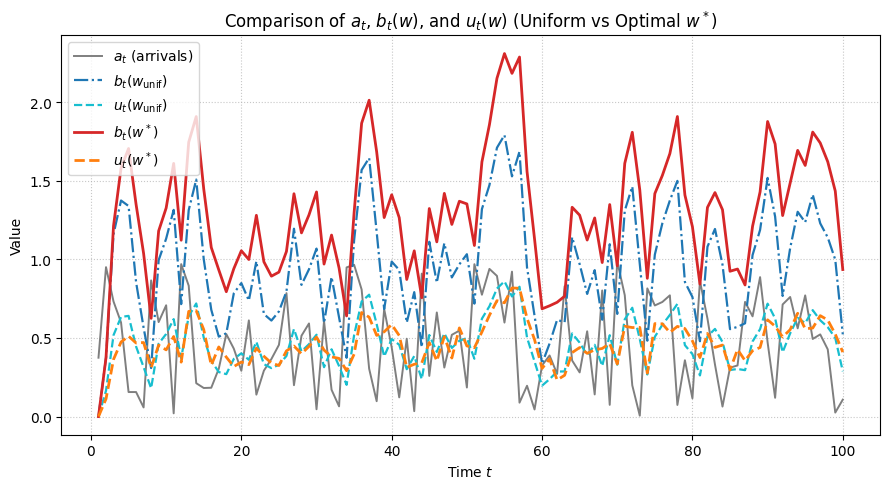

In [35]:
# --- Step 7: Compare sequences: arrivals a_t, uniform-control b_t(u), and optimal b_t(w*), u_t(w*) ---

# Define uniform simplex weight
w_uniform = np.ones(H) / H

# Compute sequences for uniform w
b_uniform = np.array([b_t(t, w_uniform, Psi) for t in range(1, T + 1)])
u_uniform = np.array([u_t(t, w_uniform, Phi) for t in range(1, T + 1)])

# --- Plot all sequences ---
plt.figure(figsize=(9, 5))

plt.plot(range(1, T + 1), a, label=r"$a_t$ (arrivals)", color='tab:gray', linewidth=1.4)
plt.plot(range(1, T + 1), b_uniform, label=r"$b_t(w_{\text{unif}})$", color='tab:blue', linestyle='-.', linewidth=1.6)
plt.plot(range(1, T + 1), u_uniform, label=r"$u_t(w_{\text{unif}})$", color='tab:cyan', linestyle='--', linewidth=1.6)
plt.plot(range(1, T + 1), b_star, label=r"$b_t(w^*)$", color='tab:red', linewidth=2.0)
plt.plot(range(1, T + 1), u_star, label=r"$u_t(w^*)$", color='tab:orange', linestyle='--', linewidth=2.0)

plt.title(r"Comparison of $a_t$, $b_t(w)$, and $u_t(w)$ (Uniform vs Optimal $w^*$)")
plt.xlabel("Time $t$")
plt.ylabel("Value")
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Optimal w* for c_t = +b: [1. 0. 0. 0. 0.]
Sum of weights = 1.0000000000000193


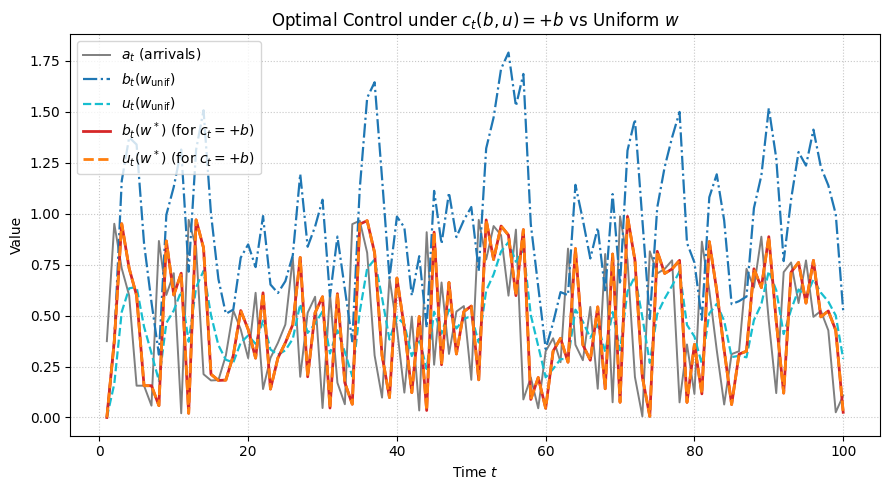

In [36]:
# --- Step 8: Solve for w* minimizing sum_t c_t(b_t(w), u_t(w)) with c_t(b,u) = +b ---

# Define new optimization problem
w2 = cp.Variable(H, nonneg=True)
objective2 = cp.Minimize(Psi_sum @ w2)  # minimize <w, sum_t psi_t>
constraints2 = [cp.sum(w2) == 1]
prob2 = cp.Problem(objective2, constraints2)
prob2.solve(verbose=False)

# Extract optimal solution
w_star2 = w2.value
print("Optimal w* for c_t = +b:", np.round(w_star2, 4))
print("Sum of weights =", np.sum(w_star2))

# Compute resulting sequences
b_star2 = np.array([b_t(t, w_star2, Psi) for t in range(1, T + 1)])
u_star2 = np.array([u_t(t, w_star2, Phi) for t in range(1, T + 1)])

# --- Plot comparison with arrivals and uniform w ---
plt.figure(figsize=(9, 5))

plt.plot(range(1, T + 1), a, label=r"$a_t$ (arrivals)", color='tab:gray', linewidth=1.4)
plt.plot(range(1, T + 1), b_uniform, label=r"$b_t(w_{\text{unif}})$", color='tab:blue', linestyle='-.', linewidth=1.6)
plt.plot(range(1, T + 1), u_uniform, label=r"$u_t(w_{\text{unif}})$", color='tab:cyan', linestyle='--', linewidth=1.6)
plt.plot(range(1, T + 1), b_star2, label=r"$b_t(w^*)$ (for $c_t=+b$)", color='tab:red', linewidth=2.0)
plt.plot(range(1, T + 1), u_star2, label=r"$u_t(w^*)$ (for $c_t=+b$)", color='tab:orange', linestyle='--', linewidth=2.0)

plt.title(r"Optimal Control under $c_t(b,u)=+b$ vs Uniform $w$")
plt.xlabel("Time $t$")
plt.ylabel("Value")
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Optimal w* for c_t(b,u) = b + (1-u)^2:
[1. 0. 0. 0. 0.]
Sum of weights = 1.0


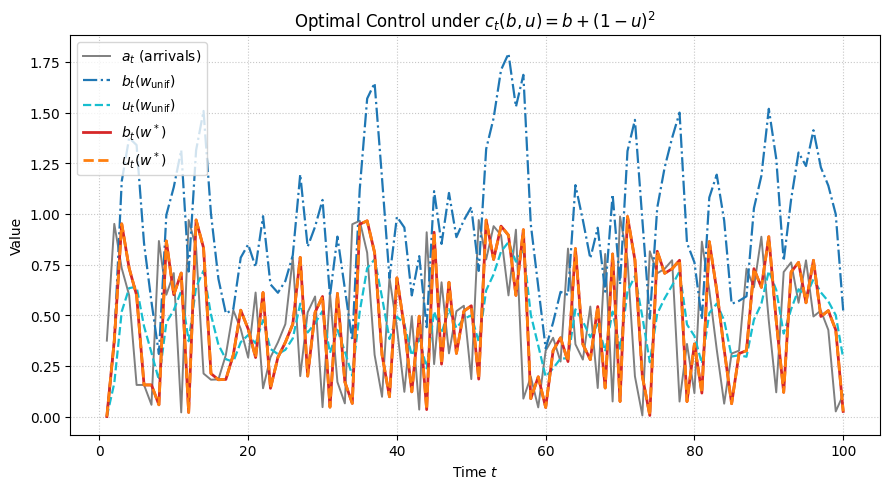

In [37]:
# --- Step 9: Solve for w* minimizing sum_t [ b_t(w) + (1 - u_t(w))^2 ] ---

# Define new optimization variable
w3 = cp.Variable(H, nonneg=True)

# Build the total cost expression
cost_terms = []
for t in range(T):
    b_expr = Psi[t, :] @ w3
    u_expr = Phi[t, :] @ w3
    cost_terms.append(b_expr + cp.square(1 - u_expr))

total_cost = cp.sum(cp.hstack(cost_terms))

# Define problem: minimize sum_t [b_t(w) + (1 - u_t(w))^2]
objective3 = cp.Minimize(total_cost)
constraints3 = [cp.sum(w3) == 1]

prob3 = cp.Problem(objective3, constraints3)
prob3.solve(verbose=False)

# Extract optimal weights
w_star3 = w3.value
print("Optimal w* for c_t(b,u) = b + (1-u)^2:")
print(np.round(w_star3, 4))
print("Sum of weights =", np.sum(w_star3))

# Evaluate resulting sequences
b_star3 = np.array([b_t(t, w_star3, Psi) for t in range(1, T + 1)])
u_star3 = np.array([u_t(t, w_star3, Phi) for t in range(1, T + 1)])

# --- Plot comparison ---
plt.figure(figsize=(9, 5))

plt.plot(range(1, T + 1), a, label=r"$a_t$ (arrivals)", color='tab:gray', linewidth=1.4)
plt.plot(range(1, T + 1), b_uniform, label=r"$b_t(w_{\text{unif}})$", color='tab:blue', linestyle='-.', linewidth=1.6)
plt.plot(range(1, T + 1), u_uniform, label=r"$u_t(w_{\text{unif}})$", color='tab:cyan', linestyle='--', linewidth=1.6)
plt.plot(range(1, T + 1), b_star3, label=r"$b_t(w^*)$", color='tab:red', linewidth=2.0)
plt.plot(range(1, T + 1), u_star3, label=r"$u_t(w^*)$", color='tab:orange', linestyle='--', linewidth=2.0)

plt.title(r"Optimal Control under $c_t(b,u) = b + (1 - u)^2$")
plt.xlabel("Time $t$")
plt.ylabel("Value")
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Using s1 = 1.0, s2 = 10
Optimal w* = [0.4532 0.4381 0.1087 0.     0.    ]
Sum of weights = 0.9999999999999999


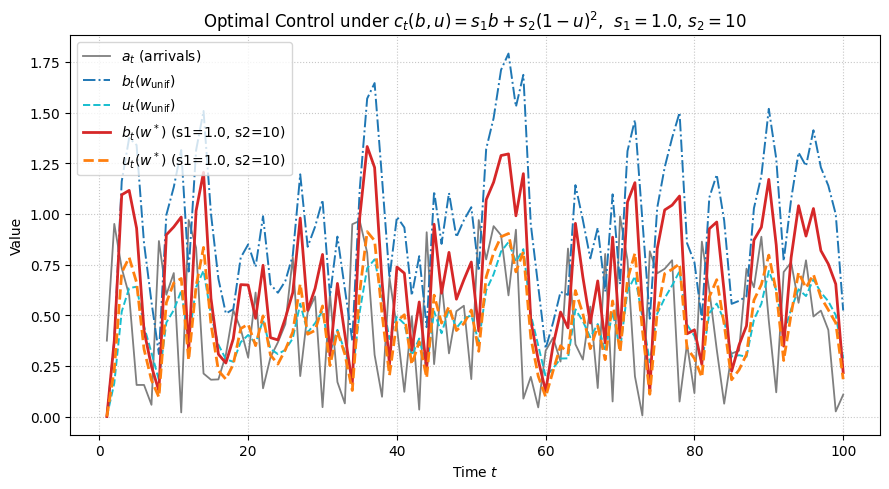

In [42]:
# --- Step 10: Solve for w* minimizing sum_t [ s1 * b_t(w) + s2 * (1 - u_t(w))^2 ] ---

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Trade-off parameters
s1 = 1.0   # weight on b_t(w)
s2 = 10  # weight on (1 - u_t(w))^2
print(f"Using s1 = {s1}, s2 = {s2}")

# Optimization variable
w4 = cp.Variable(H, nonneg=True)

# Build cost expression
cost_terms = []
for t in range(T):
    b_expr = Psi[t, :] @ w4
    u_expr = Phi[t, :] @ w4
    cost_terms.append(s1 * b_expr + s2 * cp.square(1 - u_expr))

total_cost = cp.sum(cp.hstack(cost_terms))

# Define and solve optimization problem
objective4 = cp.Minimize(total_cost)
constraints4 = [cp.sum(w4) == 1]
prob4 = cp.Problem(objective4, constraints4)
prob4.solve(verbose=False)

# Extract optimal weights
w_star4 = w4.value
print("Optimal w* =", np.round(w_star4, 4))
print("Sum of weights =", np.sum(w_star4))

# Evaluate resulting sequences
b_star4 = np.array([b_t(t, w_star4, Psi) for t in range(1, T + 1)])
u_star4 = np.array([u_t(t, w_star4, Phi) for t in range(1, T + 1)])

# --- Plot comparison ---
plt.figure(figsize=(9, 5))

plt.plot(range(1, T + 1), a, label=r"$a_t$ (arrivals)", color='tab:gray', linewidth=1.3)
plt.plot(range(1, T + 1), b_uniform, label=r"$b_t(w_{\text{unif}})$", color='tab:blue', linestyle='-.', linewidth=1.4)
plt.plot(range(1, T + 1), u_uniform, label=r"$u_t(w_{\text{unif}})$", color='tab:cyan', linestyle='--', linewidth=1.4)
plt.plot(range(1, T + 1), b_star4, label=rf"$b_t(w^*)$ (s1={s1}, s2={s2})", color='tab:red', linewidth=2.0)
plt.plot(range(1, T + 1), u_star4, label=rf"$u_t(w^*)$ (s1={s1}, s2={s2})", color='tab:orange', linestyle='--', linewidth=2.0)

plt.title(rf"Optimal Control under $c_t(b,u)=s_1 b + s_2(1-u)^2$,  $s_1={s1}$, $s_2={s2}$")
plt.xlabel("Time $t$")
plt.ylabel("Value")
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Checking recursion for uniform w:  b_(t+1) = b_t - u_t + a_t
Mean absolute error: 8.0183e-17
Max absolute error:  4.4409e-16


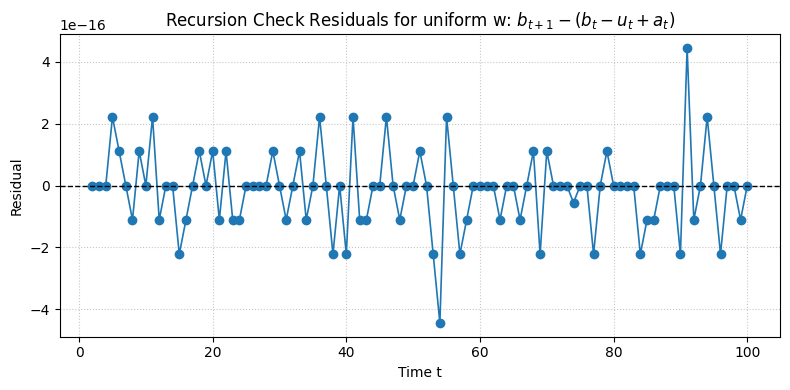

Checking recursion for optimal w*:  b_(t+1) = b_t - u_t + a_t
Mean absolute error: 8.2145e-17
Max absolute error:  4.4409e-16


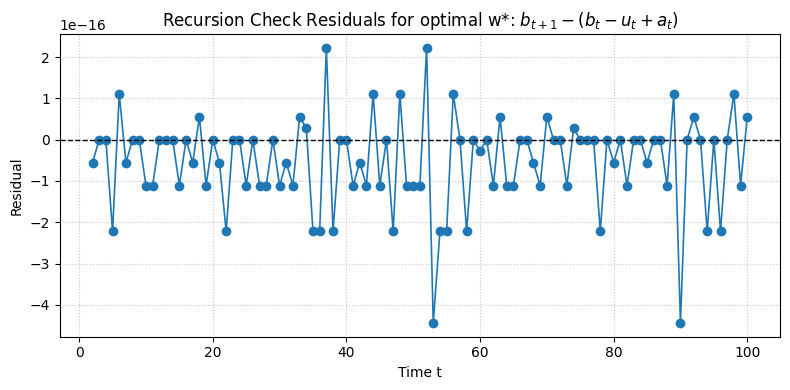

In [43]:
# --- Step 11: Check recursive relation: b_{t+1} = b_t - u_t + a_t,  b_1 = 0 ---

def check_balance(a, b_seq, u_seq, name="w*"):
    """
    Checks whether b_{t+1} = b_t - u_t + a_t holds approximately.

    Parameters
    ----------
    a : np.ndarray, shape (T,)
        Arrival sequence.
    b_seq : np.ndarray, shape (T,)
        Sequence of b_t(w) values.
    u_seq : np.ndarray, shape (T,)
        Sequence of u_t(w) values.
    name : str
        Label for printing results.
    """
    T = len(a)
    
    # Compute left and right sides
    lhs = b_seq[1:]               # b_{t+1}
    rhs = b_seq[:-1] - u_seq[:-1] + a[:-1]
    
    # Residual (difference)
    residual = lhs - rhs
    
    print(f"Checking recursion for {name}:  b_(t+1) = b_t - u_t + a_t")
    print(f"Mean absolute error: {np.mean(np.abs(residual)):.4e}")
    print(f"Max absolute error:  {np.max(np.abs(residual)):.4e}")

    # Plot residuals
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, T + 1), residual, marker='o', linestyle='-', linewidth=1.2)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.title(rf"Recursion Check Residuals for {name}: $b_{{t+1}} - (b_t - u_t + a_t)$")
    plt.xlabel("Time t")
    plt.ylabel("Residual")
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return residual


# Example checks
res_uniform = check_balance(a, b_uniform, u_uniform, name="uniform w")
res_opt = check_balance(a, b_star4, u_star4, name="optimal w*")
